# Todos
- [x] add todo (jupyter notebook tutorial)
- [x] ipdb on exception
- [x] clean code: remove argparse, run by calling function with suitable arguments
-  ~~write evaluation of upper bound performance of an abstraction~~ (This is useless since when there are 40 abstraction states, the number of policy is $4^{40}$, impossible to find out the best one)
- [ ] generate abstractions with different n_goal and n_abs, select some of them to do multi-task training and transfer

# Settings and Functions

Automatic pdb calling has been turned ON
pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
# of shown colors: 45/47


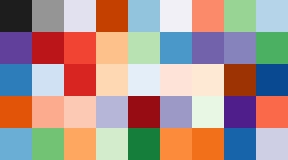

In [1]:
%pdb on

from deep_rl.gridworld import ReachGridWorld, PORGBEnv, ReachGoalManager
import sys 
import random
import argparse
import dill
import itertools
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from collections import Counter, namedtuple
from IPython.display import display
from PIL import Image

def seed(s):
    random.seed(s)
    np.random.seed(s)

seed(0) # set seed 

class one_hot:
    # 1 or 2 dim
    @staticmethod
    def encode(indices, dim):
        if len(indices.shape) > 1:
            indices = indices.squeeze(axis=1)
        assert len(indices.shape) == 1, 'shape error'
        return np.eye(dim)[indices]

    # 2-dim
    @staticmethod
    def decode(vs):
        return np.argmax(vs, 1)

# given a 2d list, concatenate each row by dim 1, and each column by dim 0
def concat2d(arr2d):
    return np.concatenate([np.concatenate(arr, axis=1) for arr in arr2d])

def imshow(img):
    display(Image.fromarray(img))

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 10)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.1 * v)) for v in range(1, 10)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.1 * v)) for v in range(1, 10)],
    *[('green-{}'.format(v), plt.cm.Greens(0.1 * v)) for v in range(1, 10)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.1 * v)) for v in range(1, 10)],
    *[('red-{}'.format(v), plt.cm.Reds(0.1 * v)) for v in range(1, 10)],
])

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
visualization_map = dict([
    ('G', 0),
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 45)],
])

def display_color_list(color_list):
    drawer = GridDrawer(color_list=color_list)
    n_shown_color = 45
    n_row = 5
    print('# of shown colors: {}/{}'.format(n_shown_color, len(drawer.color_list)))
    grid = np.arange(n_shown_color).reshape((n_row, n_shown_color // n_row))
    img = Image.fromarray(drawer.draw(grid, repeat=32))
    display(img)

display_color_list(color_list)
    
def cluster_abstraction(env, n_abs, feature_type='whole'):
    from sklearn.cluster import KMeans
    n_action = env.action_space.n
    env.reset()
    states = get_states(env)
    m = [[] for _ in range(len(states))]
    for combo in env.train_combos:
        env.reset(index=combo)
        for i, s in enumerate(states):
            env.teleport(*s)
            qs = np.array(env.get_q(0.99))
            best_actions = (qs == qs.max()).astype(int)
            if feature_type == 'whole':
                m[i].append(best_actions)
            elif feature_type == 'sample':
                sample_action = np.random.choice(np.argwhere(best_actions).squeeze(1), size=1)
                sample_action = one_hot.encode(sample_action, n_action)[0]
                m[i].append(sample_action)
            else:
                raise Exception('invalid feature type')
    m = np.array([np.concatenate(row) for row in m])
    kmeans = KMeans(n_clusters=n_abs, random_state=0).fit(m)
    abs_map = {s: label for s, label in zip(states, kmeans.labels_)}
    return abs_map

def get_abs_map(env, n_abs=40, method='cluster', method_config=dict()):
    # abs_map {(x, y): abstract state index}
    if method == 'cluster':
        abs_map = cluster_abstraction(env, n_abs, **method_config)
    else:
        raise Exception('no such method')
    return abs_map

GoalConfig = namedtuple('GoalConfig', ['map_name', 'n_goal', 'min_dis'])

def gen_multigoal_combos(goal_config):
    MAX_GOAL_NUM = 15
    goal_manager = ReachGoalManager(goal_config.map_name)
    # min_dis between goals (approximation of corelation)
    goals = goal_manager.gen_goals(MAX_GOAL_NUM + 1, min_dis=goal_config.min_dis) 
    train_combos = [(0,) + goal for goal in goals[:goal_config.n_goal]]
    test_combos = [(0,) + goals[-1]]
    return train_combos, test_combos

def gen_multigoal_env(goal_config):
    train_combos, test_combos = gen_multigoal_combos(goal_config)
    return ReachGridWorld([goal_config.map_name], train_combos, test_combos)

def get_abs_img(abs_map, env):
    m = env.get_map(0)
    print('labels:', set(abs_map.values()))
    print('count on labels:', Counter(abs_map.values()))
    for i in range(len(m)):
        for j in range(len(m[i])):
            if m[i][j] == '#': continue
            elif (i, j) in abs_map:
                m[i][j] = str(abs_map[(i, j)])
            else:
                m[i][j] = 'G'
    drawer = GridDrawer(color_list)
    img = drawer.draw([[visualization_map[m[i][j]] for j in range(len(m[i]))] for i in range(len(m))])
    return img
    
def save_abs(abs_dict, fn):
    with open(fn, 'wb') as f:
        dill.dump(abs_dict, f)
    
def load_abs(fn):
    with open(fn, 'rb') as f:
        return dill.load(fn)
    
# get all goals in train_combos
def get_goals(env, train=True):
    combos = env.unwrapped.train_combos if train else env.unwrapped.test_combos
    return [env.unwrapped.i2g[combo[1]] for combo in combos]
    
# input: an single map multigoal environment
# output: position of all states that are not goal states
def get_states(env):
    goals = get_goals(env)
    return [s for s in env.unwrapped.pos_candidates if s not in goals]

def kv2str(items, is_dict=True):
    if is_dict:
        items = list(items.items())
    return '-'.join(['{}-{}'.format(*item) for item in items])

def get_abs_fn(method, method_config, n_goal, n_abs):
    return 'data/abs/{}-{}-n_goal-{}-n_abs-{}.pkl'.format(
                                                method,
                                                kv2str(method_config),
                                                n_goal,
                                                n_abs)  

# Procedures

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 0)]
test: [(0, 1)]
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-4.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-8.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-12.pkl


/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return_n_iter=True)


saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-16.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-20.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-24.pkl


/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return_n_iter=True)


saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-28.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-32.pkl


/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (36). Possibly due to duplicate points in X.
  return_n_iter=True)


saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-36.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-40.pkl


/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (44). Possibly due to duplicate points in X.
  return_n_iter=True)


saved to data/abs/cluster-feature_type-whole-n_goal-1-n_abs-44.pkl
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 0), (0, 1)]
test: [(0, 2)]
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-4.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-8.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-12.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-16.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-20.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-24.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-28.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-32.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-36.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-40.pkl


/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (39) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (39) found smaller than n_clusters (44). Possibly due to duplicate points in X.
  return_n_iter=True)


saved to data/abs/cluster-feature_type-whole-n_goal-2-n_abs-44.pkl
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 0), (0, 1), (0, 2)]
test: [(0, 3)]
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-4.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-8.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-12.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-16.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-20.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-24.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-28.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-32.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-36.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-40.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-3-n_abs-44.pkl
WARN: gym.spaces.Box autodetect

saved to data/abs/cluster-feature_type-whole-n_goal-11-n_abs-28.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-11-n_abs-32.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-11-n_abs-36.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-11-n_abs-40.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-11-n_abs-44.pkl
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 4), (0, 0), (0, 5), (0, 7), (0, 10), (0, 11), (0, 2), (0, 12), (0, 1), (0, 3), (0, 9), (0, 8)]
test: [(0, 6)]
saved to data/abs/cluster-feature_type-whole-n_goal-12-n_abs-4.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-12-n_abs-8.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-12-n_abs-12.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-12-n_abs-16.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-12-n_abs-20.pkl
saved to data/abs/cluster-feature_type-whole-n_goal-12-n_abs-24.pkl
saved to dat

labels: {0, 1, 2, 3, 4, 5, 6, 7}
count on labels: Counter({6: 22, 2: 22, 0: 21, 3: 17, 5: 17, 1: 16, 7: 12, 4: 11})
labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
count on labels: Counter({0: 22, 3: 21, 2: 15, 6: 14, 5: 11, 1: 10, 9: 9, 4: 9, 10: 8, 8: 8, 7: 7, 11: 4})
labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
count on labels: Counter({2: 22, 3: 18, 1: 10, 13: 9, 9: 9, 7: 9, 4: 8, 5: 8, 10: 8, 8: 7, 14: 7, 6: 6, 11: 5, 0: 5, 12: 4, 15: 3})
labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
count on labels: Counter({2: 14, 3: 14, 5: 10, 6: 9, 4: 8, 17: 8, 14: 8, 15: 8, 13: 7, 8: 7, 16: 6, 7: 6, 18: 5, 11: 5, 19: 5, 9: 4, 1: 4, 12: 4, 0: 3, 10: 3})
labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
count on labels: Counter({1: 14, 10: 10, 2: 10, 11: 8, 7: 8, 6: 8, 18: 8, 3: 7, 8: 6, 14: 6, 5: 6, 9: 5, 17: 5, 12: 5, 13: 4, 0: 4, 23: 4, 4: 4, 22: 4, 16: 3, 19: 3, 21: 3, 20: 2, 15: 1})
labels: {0, 1

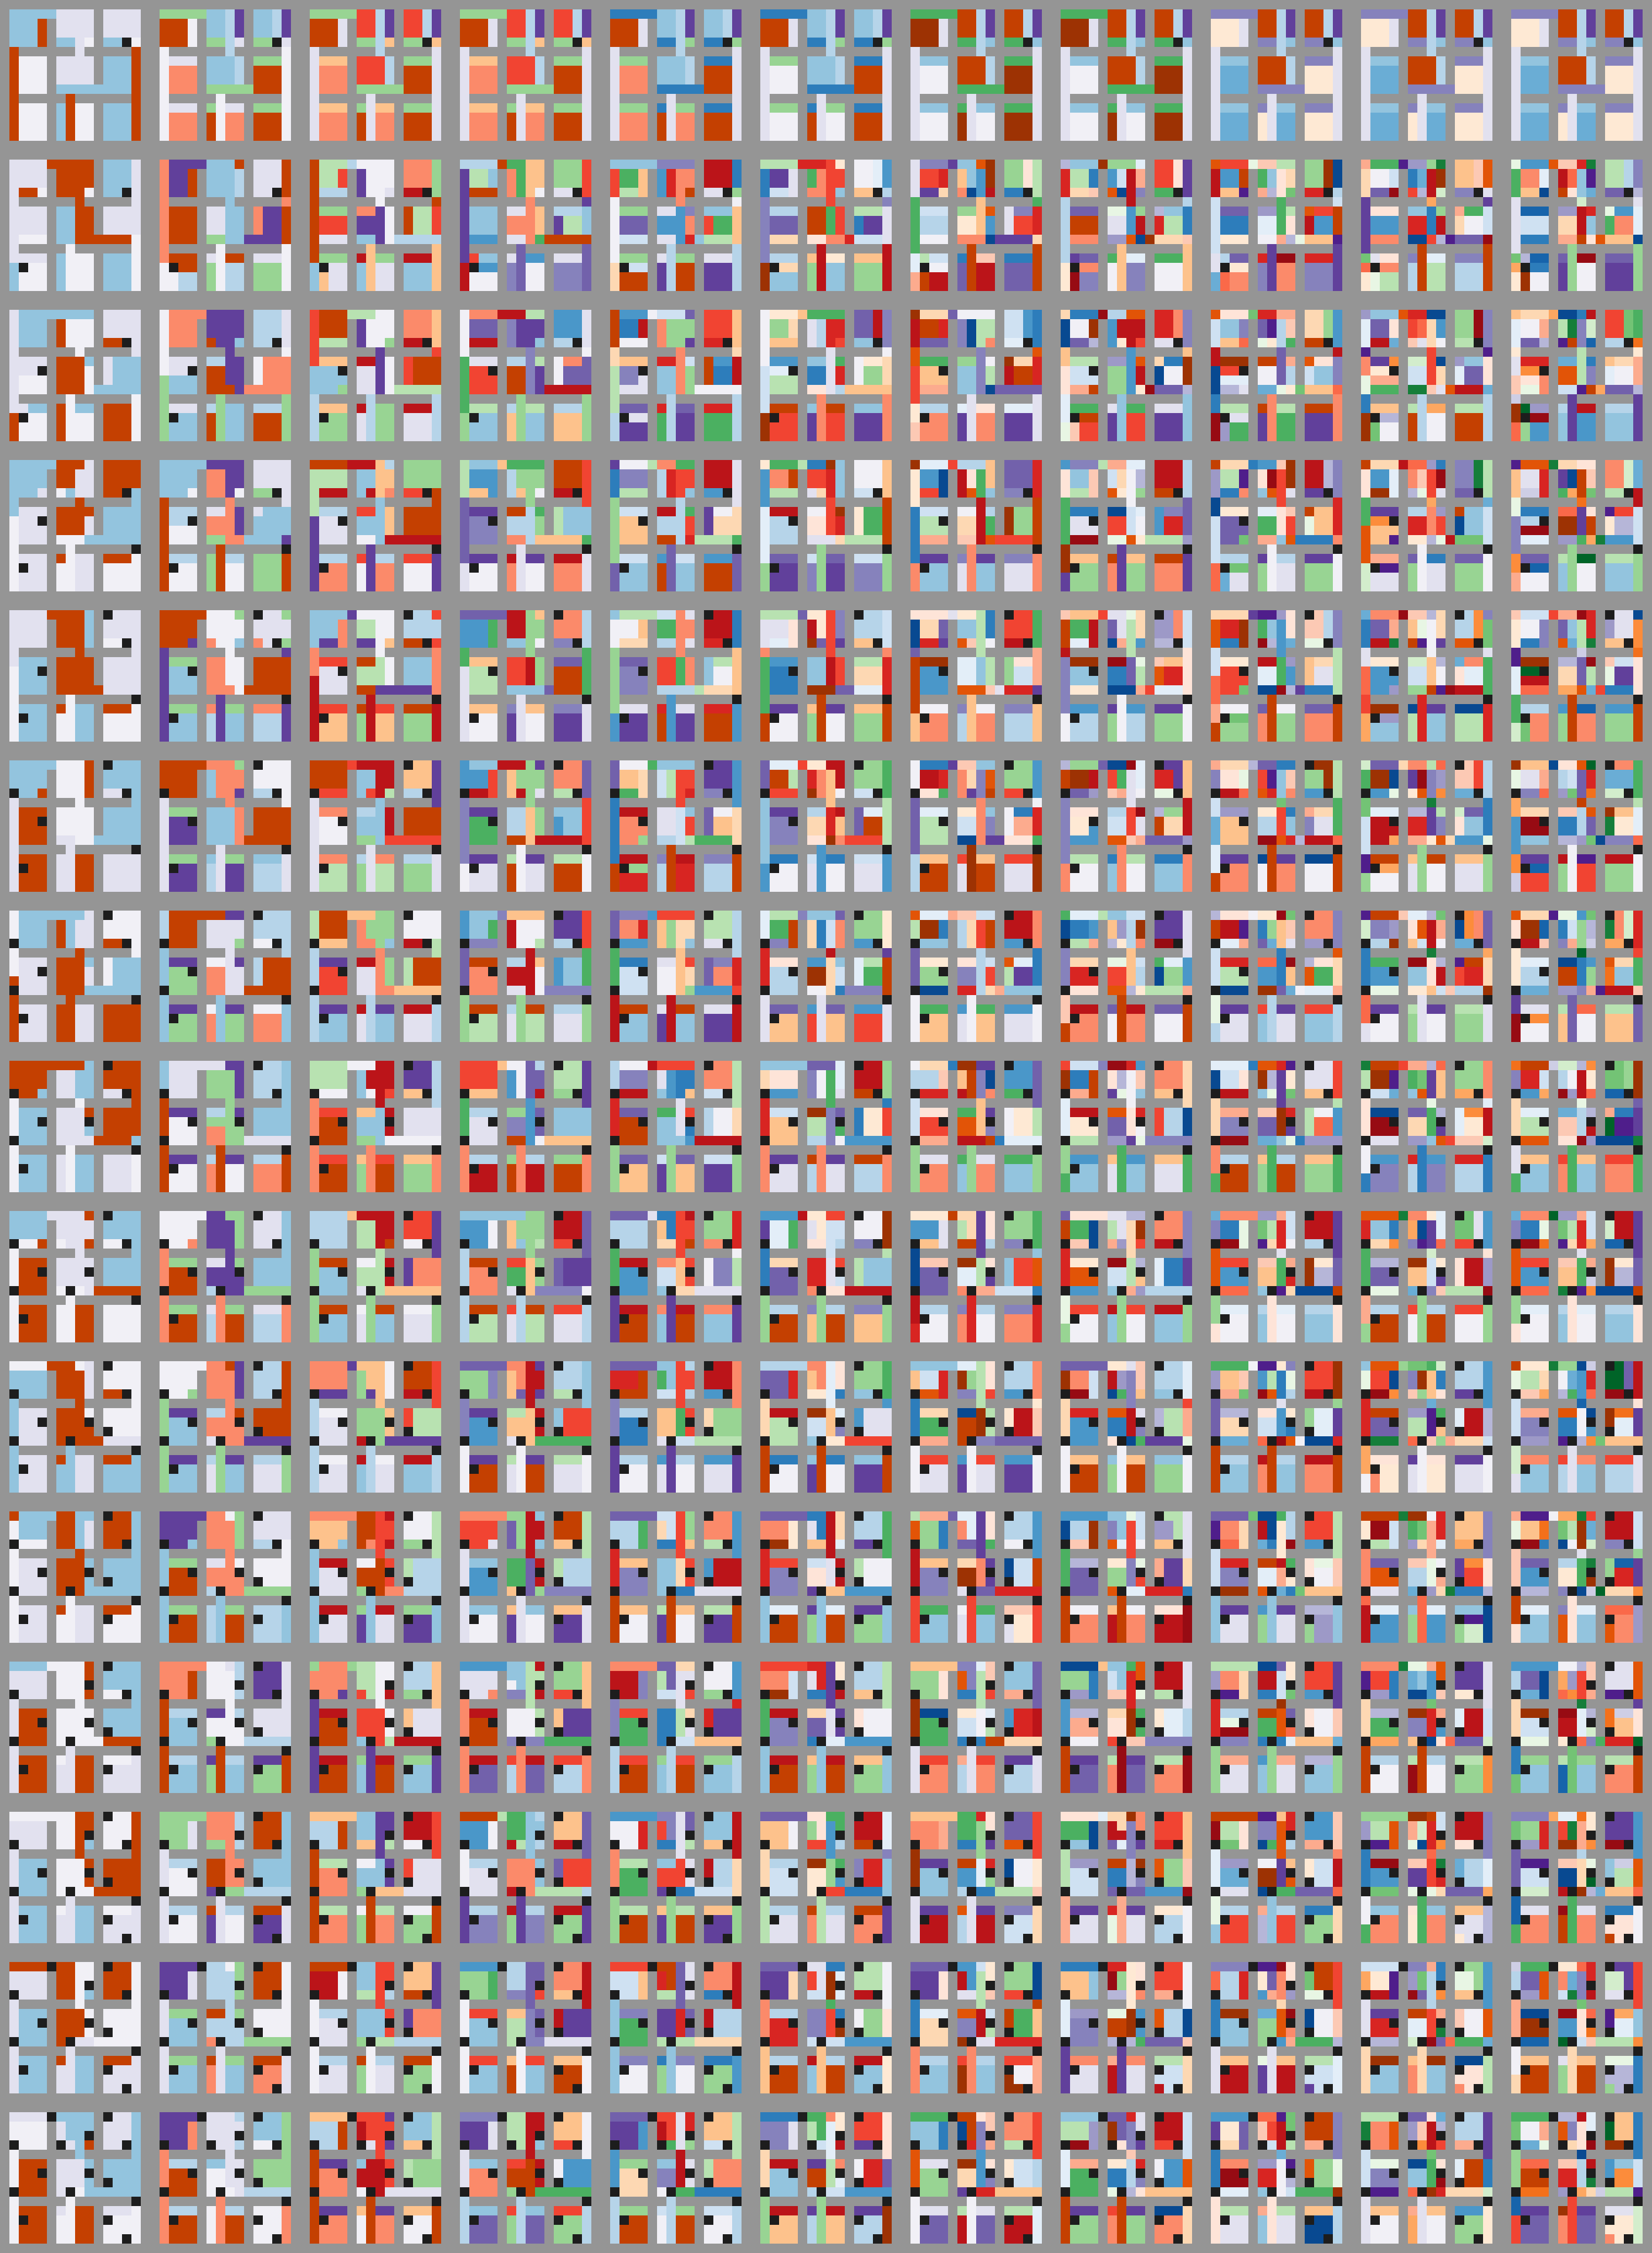

In [4]:
# input: an environment and the corresponding index (map_id, gx, gy)
# output: an identity map of this map_id and task
def get_identity_map():
    map_names = ['map49']
    train_combos = [(0, 1, 1)]
    test_combos = [(0, 2, 2)]
    env = ReachGridWorld(map_names, train_combos, test_combos)
    env.reset()
    goal = (env.unwrapped.gx, env.unwrapped.gy)
    states = [s for s in env.pos_candidates if s != goal]
    n_states = len(states)
    id_map = dict([(s, i) for i, s in enumerate(states)])
    #print(id_map)
    return id_map

# get abstraction map by a chosen method
# specify the number of abstract states, number of goals and the minimum distance between goal states
def gen_abs_map(goal_config, n_abs=40, method='cluster', method_config=dict()):
    env = gen_multigoal_env(goal_config)
    abs_map = get_abs_map(env, n_abs=n_abs, method=method, method_config=method_config)
    imshow(gen_abs_img(abs_map, env))
    save_abs({0: abs_map}, get_abs_fn(method, method_config, goal_config.n_goal, n_abs))
    print('save abs_map to {}'.format(abs_fn))

def gen_abs_maps(n_goal_range, n_abs_range, method, method_config=dict()):
    abs_maps = [[] for _ in n_goal_range] # n_goal x n_abs
    for i, n_goal in enumerate(n_goal_range):
        goal_config = GoalConfig('map49', n_goal=n_goal, min_dis=4)
        env = gen_multigoal_env(goal_config)
        for n_abs in n_abs_range:
            goal_map = {g: n_abs + i for i, g in enumerate(env.unwrapped.train_pos)}
            abs_map = get_abs_map(env, n_abs=n_abs, method=method, method_config=method_config)
            abs_maps[i].append(abs_map)
            saved_map = {**abs_map, **goal_map}
            fn = get_abs_fn(method, method_config, n_goal, n_abs)
            save_abs({0: saved_map}, fn)
            print('saved to {}'.format(fn))
    abs_maps = concat2d([[get_abs_img(abs_map, env) for abs_map in row] for row in abs_maps])
    imshow(abs_maps)
    Image.fromarray(abs_maps).save('data/abs/abs_mat.png')

def gen_env_config(goal_config, min_dis):
    train_combos, test_combos = gen_multigoal_combos(goal_config)
    env_config = dict(
        map_names=[goal_config.map_name],
        train_combos=train_combos,
        test_combos=test_combos,
        min_dis=min_dis,
    )
    fn = '{}-n_goal-{}-min_dis-{}'.format(goal_config.map_name, goal_config.n_goal, goal_config.min_dis)
    with open('data/env_configs/{}'.format(fn), 'wb') as f:
        dill.dump(env_config, f)
        print('generate env_config: {}'.format(fn))

if __name__ == '__main__':
    seed(0)
#     gen_env_config(
#         GoalConfig(
#             map_name='map49',
#             n_goal=12,
#             min_dis=4,
#         ),
#         min_dis=10,
#     )

    gen_abs_maps(
        n_goal_range=list(range(1, 16)),
        n_abs_range=[4 * i for i in range(1, 12)],
        method='cluster',
        method_config=dict(feature_type='whole'),
    )
    
#     gen_abs_map(
#         GoalConfig(
#             map_name='map49',
#             n_goal=10,
#             min_dis=4,
#         ),
#         n_abs=10,
#         method='cluster',
#         method_config=dict(feature_type='whole'),
#     )

# Debug

In [4]:
# given a 2d list, concatenate each row by dim 1, and each column by dim 0
def concat2d(arr2d):
    return np.concatenate([np.concatenate(arr, axis=1) for arr in arr2d])

a = [[np.array([[1, 2]]), np.array([[3, 4]])], [np.array([[5, 6]]), np.array([[7, 8]])]]
print(concat2d(a))

[[1 2 3 4]
 [5 6 7 8]]
